<a href="https://colab.research.google.com/github/Flamisell/StewartPlatform_py/blob/main/Stweart_Platform_Py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stweart Platform Implementation



The StewartPlatform class provides a comprehensive toolkit for simulating and analyzing the kinematics and statics of a Stewart Platform, a type of parallel manipulator with six degrees of freedom. This class is designed to facilitate various computations and analyses related to the Stewart Platform, including inverse kinematics, forward kinematics, Jacobian matrix calculation, and force analysis. Additionally, it provides methods for workspace and kinematic index analysis, making it a versatile tool for researchers and engineers working with Stewart Platforms.

**Key Features**


1.  *Inverse Kinematics (IK)*:

*   Calculate the leg lengths required to achieve a desired pose (position and orientation) of the platform.


2.   *Forward Kinematics (FK):*

*  Determine the pose of the platform given the lengths of the legs using an iterative Newton method.

3.   *Jacobian Matrix:*

* Compute the Jacobian matrix, which relates the velocities of the platform to the velocities of the actuators.

4.   *Kinematic Indices:*

* Evaluate various kinematic indices, such as the Singular Value Index, Manipulability Index, Condition Number and Local Condition Index to analyze the performance and capabilities of the platform.

5. *Force Analysis:*

* Calculate the forces on the platform given the actuator forces and vice versa.
Determine the force ellipsoid to understand the force transmittability characteristics of the platform. Calculate the LDI (Local Design Index) for actuator selection.

6. *Workspace Analysis:*

* Analyze the reachable workspace of the platform and compute performance indices across the workspace.

7. *Singularity Finder:*

* Analyze the reachable workspace of the platform and compute force singularities across the workspace.


Hope this is useful 😀


In [ ]:
# @title Sterwart Platform Class
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

class StewartPlatform:

    def __init__(self, r_b , phi_b , r_p, phi_p):
        self.r_b = r_b # radius of base
        self.phi_b = phi_b # angle between base joints
        self.r_p = r_p # radius of platform
        self.phi_p = phi_p # angle between platform joints
        self.options = {
            1: self.getSingularValueIndex,
            2: self.getManipulabilityIndex,
            3: self.getConditionNumber,
            4: self.getLocalConditionIndex,
            5: self.getLDI,
            6: self.getLocalConditionIndexT
        }


    ############################################ IK ##############################################
    def __inverse_kinematics(self, pose): ## Inverse Kinematics (Vectorial Closing Loop)
        if len(pose) != 6:
            raise ValueError("Pose must be a 6-element list or array")

        self.p_i = np.zeros([6, 3])
        self.b_i = np.zeros([6, 3])
        self.l_i = np.zeros([6, 3])
        self.l_i_unit = np.zeros([6, 3])

        self.pose_vect = pose
        x_p, y_p, z_p, roll, pitch, yaw = pose

        self.r = R.from_euler("ZYX", (yaw, pitch, roll), degrees=True)  #rotation matrix
        angles = np.array([0, 120, 120, 240, 240, 0])

        for i in range(6):
            j = -1 if (i % 2) == 1 else 1
            self.b_i[i, 0] = self.r_b * np.cos(np.deg2rad(angles[i] + j * self.phi_b / 2)) # base points
            self.b_i[i, 1] = self.r_b * np.sin(np.deg2rad(angles[i] + j * self.phi_b / 2))
            self.p_i[i, 0] = self.r_p * np.cos(np.deg2rad(angles[i] + j * self.phi_p / 2)) # platform points
            self.p_i[i, 1] = self.r_p * np.sin(np.deg2rad(angles[i] + j * self.phi_p / 2))
            self.l_i[i, :] = np.array([x_p, y_p, z_p]) + self.r.as_matrix().dot(self.p_i[i]) - self.b_i[i] # legs vectors
            self.l_i_unit[i, :] = self.l_i[i, :] / np.linalg.norm(self.l_i[i, :]) # unit legs vectors
            self.p_i[i] = self.l_i[i, :] + self.b_i[i] # moving platform points wrt base frame

        return self.l_i

    def getIK(self, pose):
        return self.__inverse_kinematics(pose)

    ############################################ Jacobian ##############################################
    def __jacobian(self): # Calculate Jacobian q_dot=Jacobian*x_dot
        if not hasattr(self, 'l_i_unit') or not hasattr(self, 'p_i'):
            raise AttributeError("Run inverse kinematics before calculating the Jacobian")
        self.jacobian = np.zeros([6, 6])
        for i in range(6):
            lastcols = np.cross(self.r.as_matrix().dot(self.p_i[i]), self.l_i_unit[i])
            self.jacobian[i, :3] = self.l_i_unit[i]
            self.jacobian[i, 3:] = lastcols

        return self.jacobian

    def getJacobian(self):
        return self.__jacobian()

    ############################################ FK ##############################################
    def __forward_kinematics(self, starting_pose, lengths_desired, plot_flag): # Newton Method Optimization.
        if not isinstance(starting_pose, (list, np.ndarray)) or len(starting_pose) != 6:
            raise ValueError("Starting pose must be a list or numpy array with 6 elements")
        if not isinstance(lengths_desired, (list, np.ndarray)) or len(lengths_desired) != 6:
            raise ValueError("Lengths desired must be a list or numpy array with 6 elements")

        self.pose_vect = starting_pose
        x_p, y_p, z_p, roll, pitch, yaw = starting_pose
        self.r = R.from_euler("ZYX", (yaw, pitch, roll), degrees=True)

        # Newton Method Parameters
        max_count = 100
        epsilon = 0.001
        alpha_pos = 0.2
        alpha_rot = 0.5
        # variables
        est_pose_vect = np.copy(starting_pose)
        est_pose = np.zeros([4, 4])
        est_pose[:3, :3] = self.r.as_matrix()
        est_pose[:3, 3] = [x_p, y_p, z_p]
        est_pose[3, 3] = 1
        delta_lengths = np.zeros(6)
        delta_T = np.identity(4)
        error = epsilon + 1
        count = 0

        while error > epsilon and count < max_count:
            # find new variables
            legs_est = self.__inverse_kinematics(est_pose_vect)
            lengths_est = np.linalg.norm(legs_est, axis=1)
            delta_lengths = lengths_desired - lengths_est
            J = self.__jacobian()
            J_T = J.transpose()
            # find x_delta with pseudoinverse
            J_star = np.linalg.inv(J_T.dot(J) + 0.0001 * np.identity(6)).dot(J_T)
            x_delta = np.dot(J_star, delta_lengths)
            x_delta_pos = x_delta[:3] * alpha_pos
            x_delta_rot = x_delta[3:] * alpha_rot
            # transform x_delta to delta_T
            r_delta = R.from_euler("ZYX", x_delta_rot)
            delta_T[:3, :3] = r_delta.as_matrix()
            delta_T[:3, 3] = x_delta[:3]
            # move pose
            est_pose = np.dot(delta_T, est_pose)
            # transform est_pose to est_pose_vect
            est_pose_vect[:3] = est_pose[:3, 3]
            self.r_pos = R.from_matrix(est_pose[:3, :3])
            est_pose_vect[3:] = self.r_pos.as_euler("ZYX", degrees=True)
            # find error and update counter
            error = np.linalg.norm(delta_lengths)
            count += 1

            # Uncomment to plot during FK procedure
            if plot_flag:
              self.plot()

        if count < max_count:
            self.pose_vect = est_pose_vect
            print("Forward Kinematics converged!")
            print("Estimated pose:", est_pose_vect)
            print("Desired Lengths:", lengths_desired)
            print("Estimated Lengths:", lengths_est)
            print("Error:", error)
            print("Iterations:", count)
        else:
            print("Forward Kinematics did not converge")
            print("Estimated pose:", est_pose_vect)
            print("Desired Lengths:", lengths_desired)
            print("Estimated Lengths:", lengths_est)
            print("Error:", error)
            print("Iterations:", count)

        return self.pose_vect

    def getFK(self, starting_pose, lengths_desired, plot_flag):
        return self.__forward_kinematics(starting_pose, lengths_desired, plot_flag)

    ############################################ Kinematic Analysis ##############################################
    def __find_singular_value_index(self): # measures drive capability of the platform, finds max q_dot under unitary x_dot
        J = self.__jacobian()
        eigenvalues = np.linalg.eigvals(J.T.dot(np.linalg.inv(J)))
        sigma_max = np.abs(np.sqrt(np.max(eigenvalues)))
        return sigma_max

    def getSingularValueIndex(self):
        return self.__find_singular_value_index()

    def __find_manipulability_index(self): # Measures manipulability of manipulator, can be used to optimize it's configuration
        J = self.__jacobian()
        JJ = J.dot(J.T)
        w = np.sqrt(np.linalg.det(JJ))
        return w

    def getManipulabilityIndex(self):
        return self.__find_manipulability_index()

    def __find_condition_number(self): # Measures closeness to isotropic configuration [1,+ inf)
        J = self.__jacobian()
        cond_num = np.linalg.cond(J)
        return cond_num

    def getConditionNumber(self):
        return self.__find_condition_number()

    def __find_local_condition_index(self): # Measures closeness to isotropic configuration (0,1]
        eta = 1 / self.__find_condition_number()
        return eta

    def getLocalConditionIndex(self):
        return self.__find_local_condition_index()

    ############################################ Force Analysis ##############################################
    def __find_platform_forces(self, F_actuators): # Finds platform forces given by actuator forces
        if not isinstance(F_actuators, (list, np.ndarray)) or len(F_actuators) != 6:
            raise ValueError("F_actuators must be a list or numpy array with 6 elements")
        J_T = self.__jacobian().T
        F_platform = J_T.dot(F_actuators)
        return F_platform

    def getPlatformForces(self, F_actuators):
        return self.__find_platform_forces(F_actuators)

    def __find_actuator_forces(self, F_platform): # Finds actuator forces given by platform forces
        if not isinstance(F_platform, (list, np.ndarray)) or len(F_platform) != 6:
            raise ValueError("F_platform must be a list or numpy array with 6 elements")

        J_Inv = np.linalg.inv(self.__jacobian().T) # only when Jacobian is invertible
        F_actuators = J_Inv.dot(F_platform)
        return F_actuators

    def getActuatorForces(self, F_platform):
        return self.__find_actuator_forces(F_platform)

    def __find_force_ellipsoid(self): # Finds force ellipsoid (excluding moment vectors)
        J_T = self.__jacobian().T
        JJ = J_T.dot(J_T.T)
        A = JJ[:3, :3] # Lagrangian
        eigenvalues, eigenvectors = np.linalg.eig(A)

        Force_ellipsoid_1 = eigenvectors[:, 0] * np.abs(eigenvalues[0])
        Force_ellipsoid_2 = eigenvectors[:, 1] * np.abs(eigenvalues[1])
        Force_ellipsoid_3 = eigenvectors[:, 2] * np.abs(eigenvalues[2])

        return [Force_ellipsoid_1, Force_ellipsoid_2, Force_ellipsoid_3]

    def getForceEllipsoid(self):
        return self.__find_force_ellipsoid()

    def __find_ldi(self):  # Local design index for Force transmittability (actuator design)
        J_T = self.__jacobian().T
        JJ = J_T.dot(J_T.T)
        A = JJ[:3, :3] # Lagrangian
        eigenvalues, _ = np.linalg.eig(A)
        R_f = np.abs(np.sqrt(np.min(eigenvalues))) # take minimum magnitude of force ellipsoid for actuator design
        LDI_f = 1 / R_f # local design index
        return LDI_f

    def getLDI(self):
        return self.__find_ldi()

    def __find_local_condition_index_T(self):  # Measures closeness to isotropic force configuration (0,1] 0 is singularity.
      J_T = self.__jacobian().T
      cond_num = np.linalg.cond(J_T)
      eta_T = 1 / cond_num
      return eta_T

    def getLocalConditionIndexT(self):
      return self.__find_local_condition_index_T()

    ############################################ Workspace Analysis #########################################

    def __find_index_workspace_position(self, workspace_limits, RPY, N, choice):
        # Validate inputs
        if not isinstance(workspace_limits, (list, np.ndarray)) or len(workspace_limits) != 6:
            raise ValueError("workspace_limits must be a list or array of 6 elements")
        if not isinstance(RPY, (list, np.ndarray)) or len(RPY) != 3:
            raise ValueError("RPY must be a list or array of 3 elements")
        if not isinstance(N, int) or N <= 0:
            raise ValueError("N must be a positive integer")
        if choice not in self.options:
            raise ValueError(f"Invalid choice for index calculation. Valid choices are: {list(self.options.keys())}")

        # Define discretization space
        x_min, x_max, y_min, y_max, z_min, z_max = workspace_limits
        roll, pitch, yaw = RPY

        # Ensure workspace limits are valid
        if x_min >= x_max or y_min >= y_max or z_min >= z_max:
            raise ValueError("Workspace limits must define a valid range (min < max) for each dimension")

        # Discretization vectors
        try:
            x_vect = np.linspace(x_min, x_max, N)
            y_vect = np.linspace(y_min, y_max, N)
            z_vect = np.linspace(z_min, z_max, N)
        except Exception as e:
            raise ValueError(f"Error in creating discretization vectors: {e}")

        xx, yy, zz = np.meshgrid(x_vect, y_vect, z_vect, indexing='ij')
        positions = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T
        orientations = np.array([roll, pitch, yaw])

        Holder = []

        for pos in positions:
            p_vect = np.hstack((pos, orientations))
            try:
                self.getIK(p_vect)
                Index = self.options[choice]()
                Holder.append(np.append(pos, Index))
            except Exception as e:
                print(f"Error in calculating index for position {pos}: {e}")
                continue

        if not Holder:
            raise RuntimeError("No valid indices calculated. Check the input parameters and IK method.")

        Holder = np.array(Holder)
        return Holder

    def getIndexWorkspacePosition(self, workspace_limits, RPY, N, choice):
        return self.__find_index_workspace_position(workspace_limits, RPY, N, choice)

    def __find_index_workspace_orientation(self, position, orientation_limits, N, choice):
        # Validate inputs
        if not isinstance(position, (list, np.ndarray)) or len(position) != 3:
            raise ValueError("position must be a list or array of 3 elements")
        if not isinstance(orientation_limits, (list, np.ndarray)) or len(orientation_limits) != 6:
            raise ValueError("orientation_limits must be a list or array of 6 elements")
        if not isinstance(N, int) or N <= 0:
            raise ValueError("N must be a positive integer")
        if choice not in self.options:
            raise ValueError(f"Invalid choice for index calculation. Valid choices are: {list(self.options.keys())}")

        # Define discretization space
        roll_min, roll_max, pitch_min, pitch_max, yaw_min, yaw_max = orientation_limits

        # Ensure orientation limits are valid
        if roll_min >= roll_max or pitch_min >= pitch_max or yaw_min >= yaw_max:
            raise ValueError("Orientation limits must define a valid range (min < max) for each dimension")

        # Discretization vectors
        try:
            roll_vect = np.linspace(roll_min, roll_max, N)
            pitch_vect = np.linspace(pitch_min, pitch_max, N)
            yaw_vect = np.linspace(yaw_min, yaw_max, N)
        except Exception as e:
            raise ValueError(f"Error in creating discretization vectors: {e}")

        rr, pp, yy = np.meshgrid(roll_vect, pitch_vect, yaw_vect, indexing='ij')
        orientations = np.vstack([rr.ravel(), pp.ravel(), yy.ravel()]).T

        Holder = []

        for orient in orientations:
            p_vect = np.hstack((position, orient))
            try:
                self.getIK(p_vect)
                Index = self.options[choice]()
                Holder.append(np.append(orient, Index))
            except Exception as e:
                print(f"Error in calculating index for orientation {orient}: {e}")
                continue

        if not Holder:
            raise RuntimeError("No valid indices calculated. Check the input parameters and IK method.")

        Holder = np.array(Holder)
        return Holder

    def getIndexWorkspaceOrientation(self, position, orientation_limits, N, choice):
        return self.__find_index_workspace_orientation(position, orientation_limits, N, choice)

    def __find_index_workspace(self, workspace_limits, orientation_limits, N_pos, N_orient, choice):
        # Validate inputs
        if not isinstance(workspace_limits, (list, np.ndarray)) or len(workspace_limits) != 6:
            raise ValueError("workspace_limits must be a list or array of 6 elements")
        if not isinstance(orientation_limits, (list, np.ndarray)) or len(orientation_limits) != 6:
            raise ValueError("orientation_limits must be a list or array of 6 elements")
        if not isinstance(N_pos, int) or N_pos <= 0:
            raise ValueError("N_pos must be a positive integer")
        if not isinstance(N_orient, int) or N_orient <= 0:
            raise ValueError("N_orient must be a positive integer")
        if choice not in self.options:
            raise ValueError(f"Invalid choice for index calculation. Valid choices are: {list(self.options.keys())}")

        # Define discretization space for positions
        x_min, x_max, y_min, y_max, z_min, z_max = workspace_limits
        if x_min >= x_max or y_min >= y_max or z_min >= z_max:
            raise ValueError("Workspace limits must define a valid range (min < max) for each dimension")

        x_vect = np.linspace(x_min, x_max, N_pos)
        y_vect = np.linspace(y_min, y_max, N_pos)
        z_vect = np.linspace(z_min, z_max, N_pos)

        xx, yy, zz = np.meshgrid(x_vect, y_vect, z_vect, indexing='ij')
        positions = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T

        # Define discretization space for orientations
        roll_min, roll_max, pitch_min, pitch_max, yaw_min, yaw_max = orientation_limits
        if roll_min >= roll_max or pitch_min >= pitch_max or yaw_min >= yaw_max:
            raise ValueError("Orientation limits must define a valid range (min < max) for each dimension")

        roll_vect = np.linspace(roll_min, roll_max, N_orient)
        pitch_vect = np.linspace(pitch_min, pitch_max, N_orient)
        yaw_vect = np.linspace(yaw_min, yaw_max, N_orient)

        rr, pp, yy = np.meshgrid(roll_vect, pitch_vect, yaw_vect, indexing='ij')
        orientations = np.vstack([rr.ravel(), pp.ravel(), yy.ravel()]).T

        # Iterate through each position and each orientation
        Holder = []
        for pos in positions:
            for orient in orientations:
                p_vect = np.hstack((pos, orient))
                try:
                    self.getIK(p_vect)
                    Index = self.options[choice]()
                    Holder.append(np.append(p_vect, Index))
                except Exception as e:
                    print(f"Error in calculating index for position {pos} and orientation {orient}: {e}")
                    continue

        if not Holder:
            raise RuntimeError("No valid indices calculated. Check the input parameters and IK method.")

        Holder = np.array(Holder)
        return Holder

    def getIndexWorkspace(self, workspace_limits, orientation_limits, N_pos, N_orient, choice):
        return self.__find_index_workspace(workspace_limits, orientation_limits, N_pos, N_orient, choice)

    def __find_singularity_workspace(self, workspace_limits, orientation_limits, N_pos, N_orient):
        # Validate inputs
        if not isinstance(workspace_limits, (list, np.ndarray)) or len(workspace_limits) != 6:
            raise ValueError("workspace_limits must be a list or array of 6 elements")
        if not isinstance(orientation_limits, (list, np.ndarray)) or len(orientation_limits) != 6:
            raise ValueError("orientation_limits must be a list or array of 6 elements")
        if not isinstance(N_pos, int) or N_pos <= 0:
            raise ValueError("N_pos must be a positive integer")
        if not isinstance(N_orient, int) or N_orient <= 0:
            raise ValueError("N_orient must be a positive integer")


        # Define discretization space for positions
        x_min, x_max, y_min, y_max, z_min, z_max = workspace_limits
        if x_min >= x_max or y_min >= y_max or z_min >= z_max:
            raise ValueError("Workspace limits must define a valid range (min < max) for each dimension")

        x_vect = np.linspace(x_min, x_max, N_pos)
        y_vect = np.linspace(y_min, y_max, N_pos)
        z_vect = np.linspace(z_min, z_max, N_pos)

        xx, yy, zz = np.meshgrid(x_vect, y_vect, z_vect, indexing='ij')
        positions = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T

        # Define discretization space for orientations
        roll_min, roll_max, pitch_min, pitch_max, yaw_min, yaw_max = orientation_limits
        if roll_min >= roll_max or pitch_min >= pitch_max or yaw_min >= yaw_max:
            raise ValueError("Orientation limits must define a valid range (min < max) for each dimension")

        roll_vect = np.linspace(roll_min, roll_max, N_orient)
        pitch_vect = np.linspace(pitch_min, pitch_max, N_orient)
        yaw_vect = np.linspace(yaw_min, yaw_max, N_orient)

        rr, pp, yy = np.meshgrid(roll_vect, pitch_vect, yaw_vect, indexing='ij')
        orientations = np.vstack([rr.ravel(), pp.ravel(), yy.ravel()]).T

        # Select 1/condition number for J_T
        choice=6

        # Iterate through each position and each orientation
        Holder = []
        for pos in positions:
            for orient in orientations:
                p_vect = np.hstack((pos, orient))
                try:
                    self.getIK(p_vect)
                    Index = self.options[choice]()
                    if Index <0.001:
                      Holder.append(np.append(p_vect, Index))
                except Exception as e:
                    print(f"Error in calculating index for position {pos} and orientation {orient}: {e}")
                    continue

        if not Holder:
            raise RuntimeError("No valid indices calculated. Check the input parameters and IK method.")

        Holder = np.array(Holder)
        return Holder

    def getSingularityWorkspace(self, workspace_limits, orientation_limits, N_pos, N_orient): # returns the value of the local condition indexT for every point in space
        # Choosing N_pos and N_orient too high may result in a computational expensive operation, suggested values ( N_pos=10, N_orient=10 )
        # for practical usage there is the need to filter the data. Suggestion: filter by local condition index value AND by distance between data points (from scipy.spatial.distance import cdist).
        return self.__find_singularity_workspace(workspace_limits, orientation_limits, N_pos, N_orient)



    ############################################ Plot Platform ##############################################
    def plot(self):
        if not hasattr(self, 'p_i'):
          raise AttributeError("Run inverse kinematics before calling the Plot function")
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_title("Stewart Platform")

        ax.plot(self.p_i[:, 0], self.p_i[:, 1], self.p_i[:, 2], color='b', lw=3)
        ax.plot([self.p_i[5, 0], self.p_i[0, 0]], [self.p_i[5, 1], self.p_i[0, 1]], [self.p_i[5, 2], self.p_i[0, 2]], color='b', lw=3)
        ax.scatter(self.p_i[:, 0], self.p_i[:, 1], self.p_i[:, 2], color='c', marker='o')

        ax.plot(self.p_i[:, 0], self.p_i[:, 1],0, color='k', lw=1)
        ax.plot([self.p_i[5, 0], self.p_i[0, 0]], [self.p_i[5, 1], self.p_i[0, 1]], [0, 0], color='k', lw=1)

        ax.plot(self.b_i[:, 0], self.b_i[:, 1], self.b_i[:, 2], color='b')
        ax.plot([self.b_i[5, 0], self.b_i[0, 0]], [self.b_i[5, 1], self.b_i[0, 1]], [self.b_i[0, 2], self.b_i[0, 2]], color='b')
        ax.scatter(self.b_i[:, 0], self.b_i[:, 1], self.b_i[:, 2], color='c', marker='o')

        for i in range(6):
            ax.plot([self.b_i[i, 0], self.p_i[i, 0]], [self.b_i[i, 1], self.p_i[i, 1]], [self.b_i[i, 2], self.p_i[i, 2]], color='k', lw=3)

        displacement = 0.03
        for x, y, z, i in zip(self.b_i[:, 0], self.b_i[:, 1], self.b_i[:, 2], range(len(self.b_i[:, 0]))):
            ax.text(x + displacement, y + displacement, z, i)

        ax.quiver(0, 0, 0, 1, 0, 0, color='r', lw=0.5, length=0.2)
        ax.quiver(0, 0, 0, 0, 1, 0, color='g', lw=0.5, length=0.2)
        ax.quiver(0, 0, 0, 0, 0, 1, color='b', lw=0.5, length=0.2)

        x_limits = ax.get_xlim3d()
        y_limits = ax.get_ylim3d()
        z_limits = ax.get_zlim3d()
        x_range = abs(x_limits[1] - x_limits[0])
        x_middle = np.mean(x_limits)
        y_range = abs(y_limits[1] - y_limits[0])
        y_middle = np.mean(y_limits)
        z_range = abs(z_limits[1] - z_limits[0])
        z_middle = np.mean(z_limits)
        plot_radius = 0.5 * max([x_range, y_range, z_range])

        ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
        ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
        ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_zlabel('Z-axis')

        plt.show()

# Usage

**Initialization**

Create an instance of the StewartPlatform class by providing the necessary parameters: the radius of the base (r_b), the angle between base joints (phi_b), the radius of the platform (r_p), and the angle between platform joints (phi_p).

In [ ]:
# Define parameters
r_b = 0.5  # Radius of base
phi_b = 50  # Angle between base joints
r_p = 0.3  # Radius of platform
phi_p = 80  # Angle between platform joints

# Create Stewart Platform instance
platform = StewartPlatform(r_b, phi_b, r_p, phi_p)

**Inverse Kinematics(IK)**

Use the getIK method to compute the leg lengths for a given pose (position and orientation).


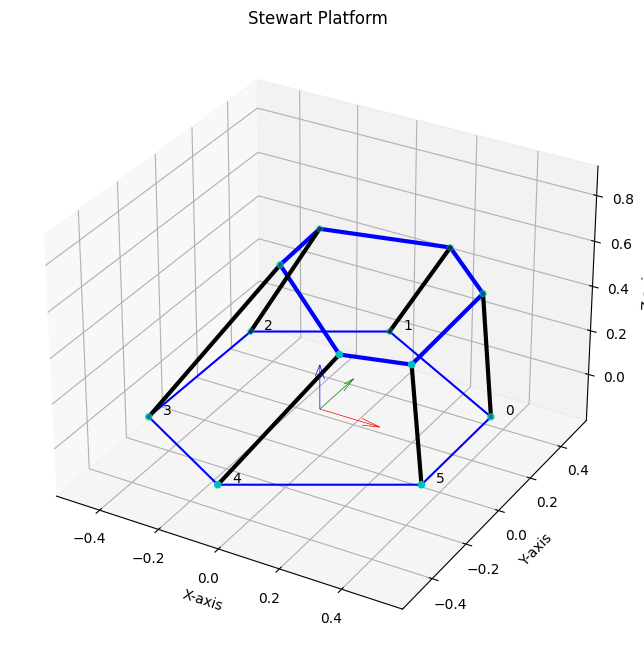

Leg Lengths: [[-0.02574723 -0.02140246  0.55286545]
 [ 0.31007731 -0.20714346  0.63039172]
 [ 0.35076325 -0.18574099  0.71316098]
 [ 0.33857546  0.18574099  0.67967531]
 [ 0.27498398  0.20714346  0.53397358]
 [-0.04865277  0.02140246  0.48993297]]


In [ ]:
pose = [0.2, 0, 0.6, 10, 20, 0]  # [x, y, z, roll, pitch, yaw]
leg_lengths = platform.getIK(pose)
platform.plot()
print("Leg Lengths:", leg_lengths)

**Forward Kinematics (FK):**

Use the getFK method to compute the pose of the platform given the initial pose and desired leg lengths.

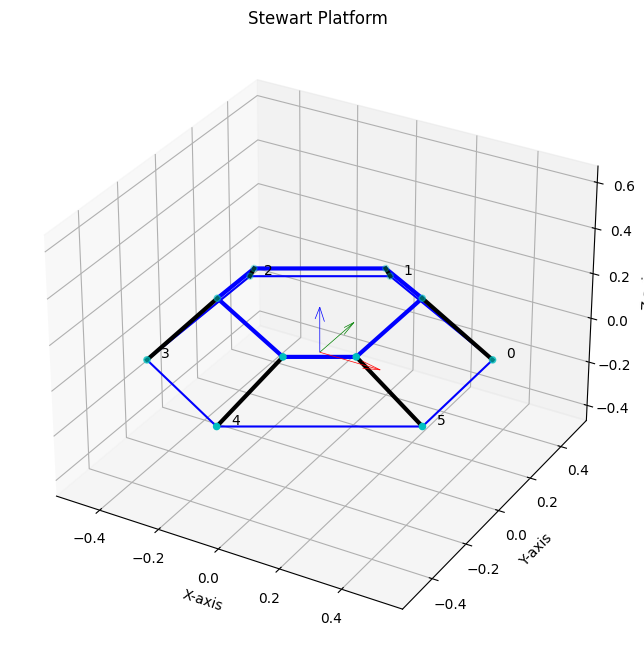

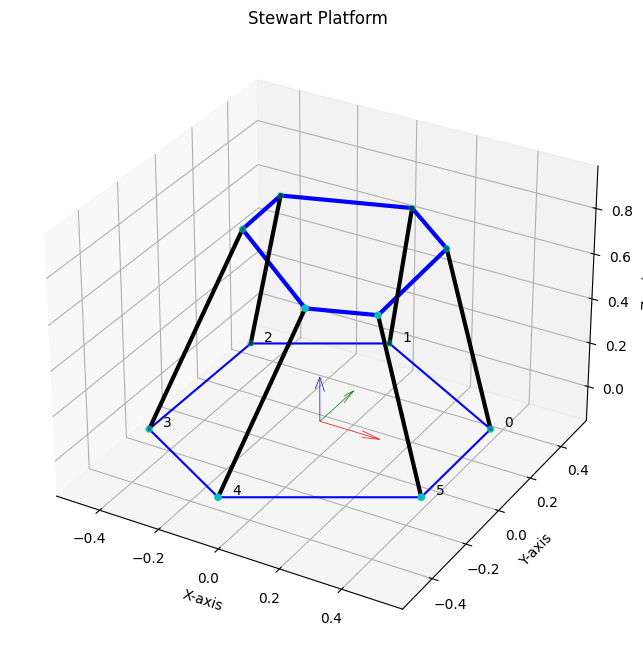

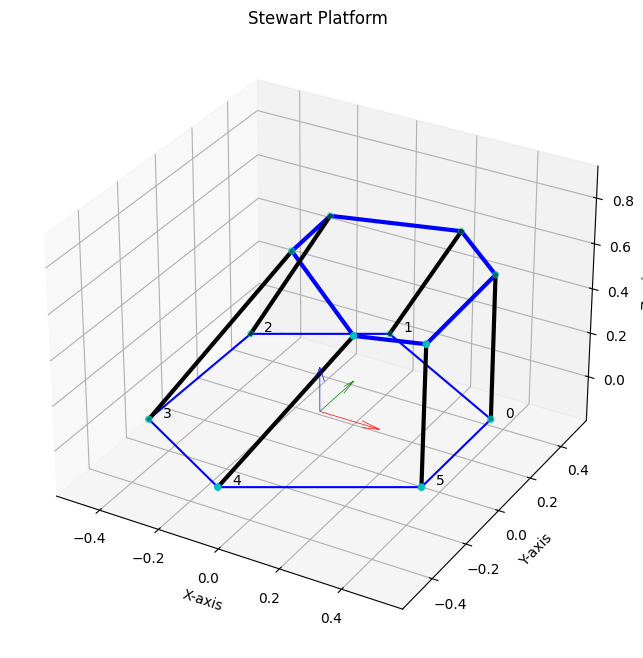

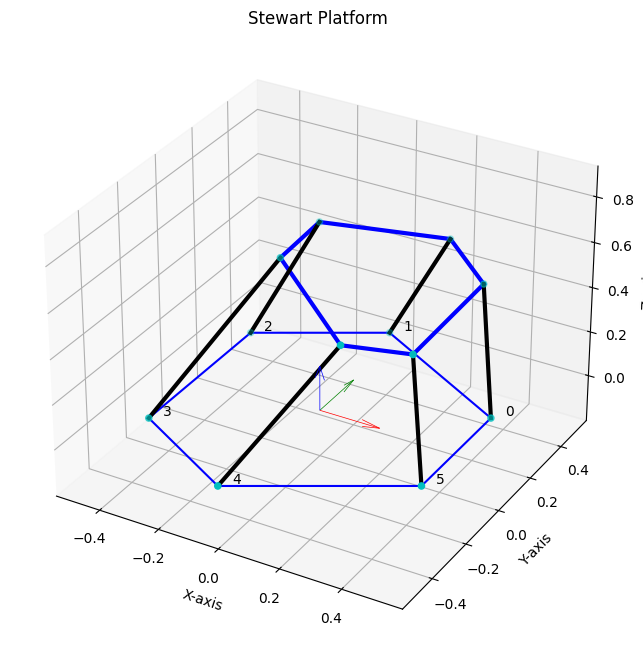

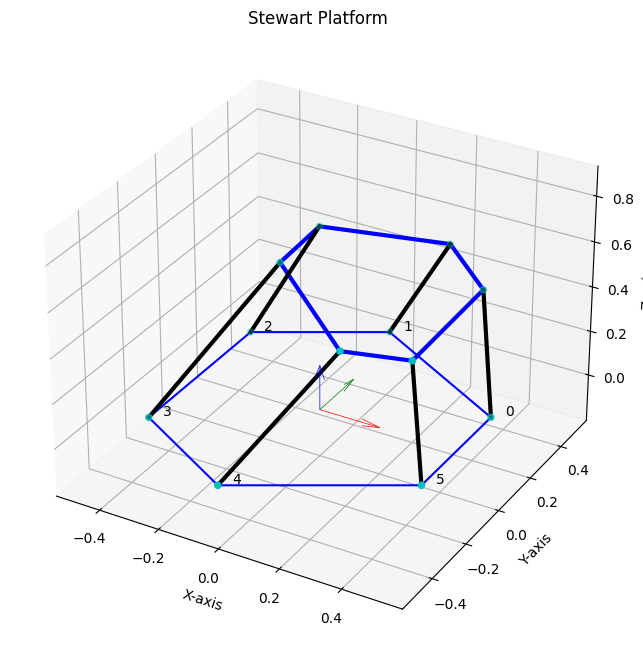

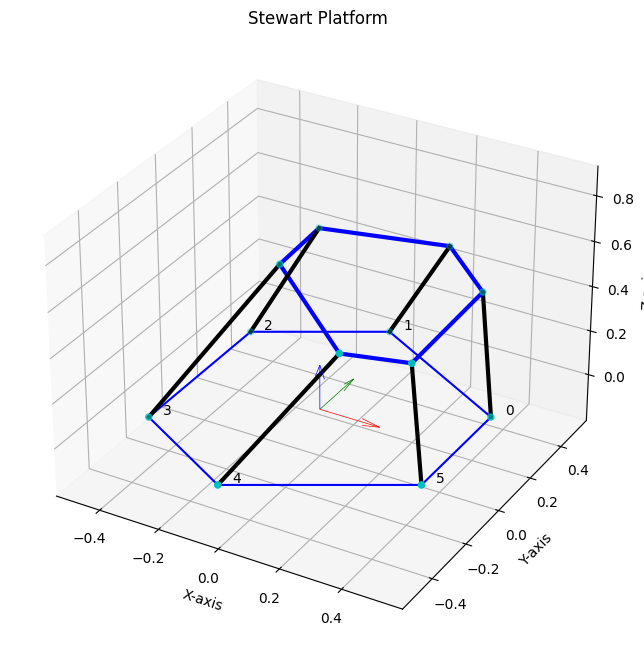

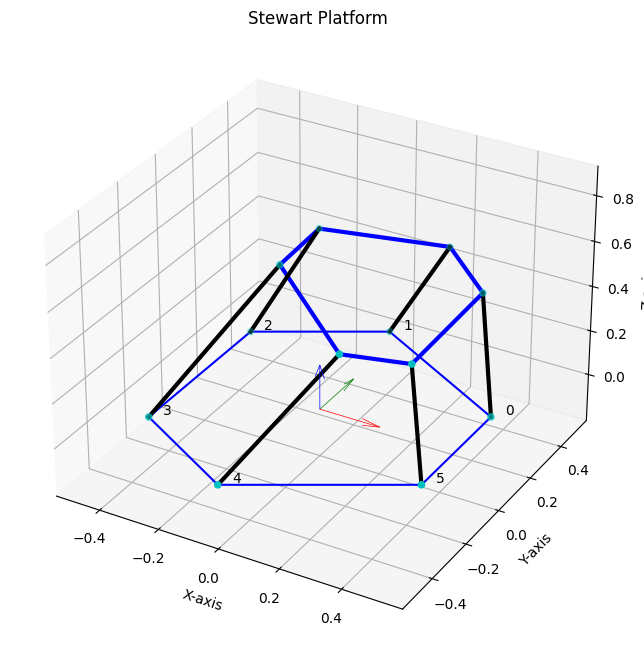

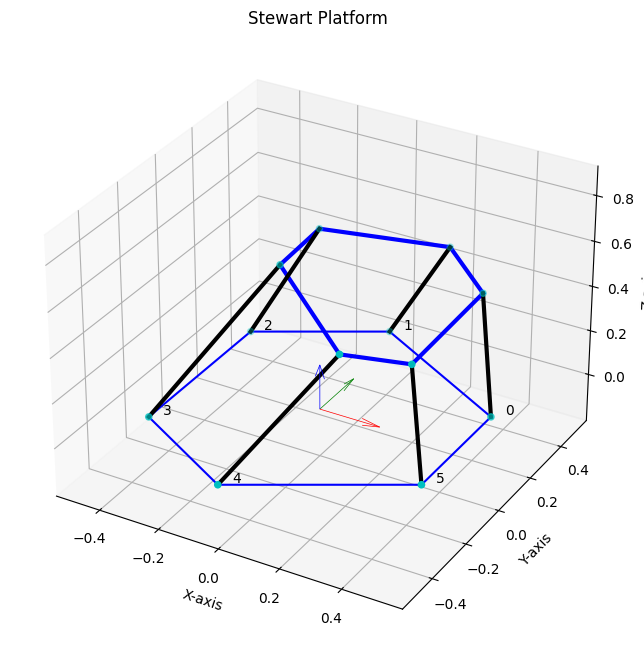

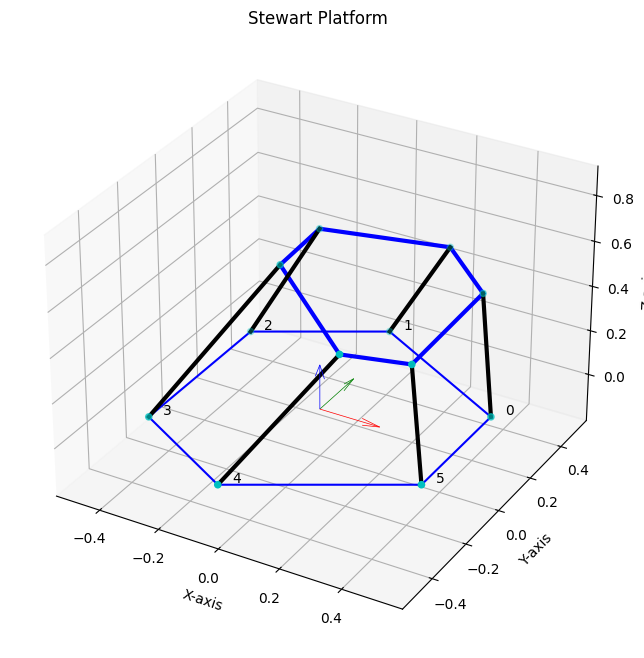

Forward Kinematics converged!
Estimated pose: [1.99983087e-01 5.36660624e-04 6.00150069e-01 1.00045583e+01
 1.99883285e+01 3.23771452e-02]
Desired Lengths: [0.55387831 0.73242752 0.8161698  0.78172347 0.63533643 0.49280775]
Estimated Lengths: [0.55438938 0.73250308 0.8161792  0.78189433 0.63584116 0.49322606]
Error: 0.0008520053529106592
Iterations: 9


In [ ]:
starting_pose = [0, 0, 0.2, 0, 0, 0]  # Initial guess for the pose
lengths_desired = np.linalg.norm(leg_lengths,axis=1)  # Use the lengths obtained from IK
plot=True
estimated_pose = platform.getFK(starting_pose, lengths_desired, plot)


**Jacobian Calculation:**


Use the getJacobian method to compute the Jacobian matrix.

In [ ]:
jacobian_matrix = platform.getJacobian()
print("Jacobian Matrix:", jacobian_matrix)

Jacobian Matrix: [[-0.04685762 -0.03722058  0.99820789  0.10670555 -0.61637248 -0.01797399]
 [ 0.42281575 -0.28196199  0.86123416  0.30560919 -0.18427063 -0.21036519]
 [ 0.42945686 -0.22720602  0.87403903  0.13728471  0.13291699 -0.03290279]
 [ 0.43294847  0.23793632  0.86944921 -0.3405214   0.14013017  0.13121659]
 [ 0.43277955  0.32673037  0.84020779 -0.43822178 -0.16042219  0.28810519]
 [-0.0983694   0.04494908  0.99413432 -0.28224805 -0.55909493 -0.00264931]]


**Kinematic and Force Analysis:**

Use various methods to analyze the platform's kinematic and force characteristics.

In [ ]:
# Get Singular Value Index
# measures drive capability of the platform, finds max q_dot under unitary x_dot
singular_value_index = platform.getSingularValueIndex()
print("Singular Value Index:", singular_value_index)

# Get Manipulability Index
# Measures manipulability of manipulator, can be used to optimize it's configuration
manipulability_index = platform.getManipulabilityIndex()
print("Manipulability Index:", manipulability_index)

# Get Condition Number
# Measures closeness to isotropic configuration [1,+ inf)
condition_number = platform.getConditionNumber()
print("Condition Number:", condition_number)

# Get Local Condition Index
# Measures closeness to isotropic configuration (0,1]
local_condition_index = platform.getLocalConditionIndex()
print("Local Condition Index:", local_condition_index)

# Calculate Platform Forces given Actuator Forces
F_actuators = [10, 10, 10, 10, 10, 10]  # Example actuator forces
F_platform = platform.getPlatformForces(F_actuators)
print("Platform Forces:", F_platform)

# Calculate Actuator Forces given Platform Forces
F_platform = [10, 10, 10, 10, 10, 10]  # Example platform forces
F_actuators = platform.getActuatorForces(F_platform)
print("Actuator Forces:", F_actuators)

# Get Force Ellipsoid
force_ellipsoid = platform.getForceEllipsoid()
print("Force Ellipsoid:", force_ellipsoid)

# Get Local Design Index (LDI)
# Local design index for Force transmittability (actuator design)
ldi = platform.getLDI()
print("Local Design Index:", ldi)


Singular Value Index: 2.556764167271041
Manipulability Index: 0.0059894653804115254
Condition Number: 25.147212659888595
Local Condition Index: 0.03976583860505
Platform Forces: [ 15.7277362    0.63227166  54.37272395  -5.11391774 -12.47113067
   1.55430505]
Actuator Forces: [ 81.51893235 -33.45741516   6.83202024  43.28723714  -4.33241909
 -83.01247166]
Force Ellipsoid: [array([1.49145241, 0.05568353, 5.12828393]), array([ 0.34421828,  0.05809266, -0.10073935]), array([ 0.04623771, -0.2917985 , -0.01027887])]
Local Design Index: 1.8392240376393167


**Workspace Analysis:**

*   Use getIndexWorkspacePosition to calculate an index over a range of positions in the workspace.
*   Use getIndexWorkspaceOrientation to calculate an index over a range of orientations for a given position.



In [ ]:
# Define workspace limits [x_min, x_max, y_min, y_max, z_min, z_max]
workspace_limits = [-0.5, 0.5, -0.5, 0.5, 0.1, 0.6]
RPY = [0, 0, 0]  # Fixed orientation (roll, pitch, yaw)
N = 10  # Number of points in each dimension
choice = 4  # Choice of index calculation (1: Singular Value Index, etc.)
            # self.options = {
            #     1: self.getSingularValueIndex, # measures drive capability of the platform, finds max q_dot under unitary x_dot
            #     2: self.getManipulabilityIndex,# Measures manipulability of manipulator, can be used to optimize it's configuration
            #     3: self.getConditionNumber,# Measures closeness to isotropic configuration [1,+ inf)
            #     4: self.getLocalConditionIndex,# Measures closeness to isotropic configuration (0,1]
            #     5: self.getLDI # Local design index for Force transmittability (actuator design)
            # }

workspace_indices_position = platform.getIndexWorkspacePosition(workspace_limits, RPY, N, choice)
print("Workspace Indices (Position):", workspace_indices_position)

# Define orientation limits [roll_min, roll_max, pitch_min, pitch_max, yaw_min, yaw_max]
orientation_limits = [-10, 10, -10, 10, -10, 10]
position = [0, 0, 0.4]  # Fixed position

workspace_indices_orientation = platform.getIndexWorkspaceOrientation(position, orientation_limits, N, choice)
print("Workspace Indices (Orientation):", workspace_indices_orientation)

Workspace Indices (Position): [[-0.5        -0.5         0.1         0.0080241 ]
 [-0.5        -0.5         0.15555556  0.01215732]
 [-0.5        -0.5         0.21111111  0.01588389]
 ...
 [ 0.5         0.5         0.48888889  0.026316  ]
 [ 0.5         0.5         0.54444444  0.02711941]
 [ 0.5         0.5         0.6         0.02760619]]
Workspace Indices (Orientation): [[-10.         -10.         -10.           0.05148484]
 [-10.         -10.          -7.77777778   0.05222069]
 [-10.         -10.          -5.55555556   0.05273243]
 ...
 [ 10.          10.           5.55555556   0.04975334]
 [ 10.          10.           7.77777778   0.04946051]
 [ 10.          10.          10.           0.04894839]]


You can use Plotly to better visualize your indeces across workspace.

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
# @title Plotly
values = workspace_indices_position[:, 3]
X = workspace_indices_position[:, 0]
Y = workspace_indices_position[:, 1]
Z = workspace_indices_position[:, 2]

x_min, x_max = np.min(X), np.max(X)
y_min, y_max = np.min(Y), np.max(Y)
z_min, z_max = np.min(Z), np.max(Z)

isomin_val, isomax_val = np.min(values), np.max(values)

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    opacity=0.2,  # needs to be small to see through all surfaces
    surface_count=20,  # needs to be a large number for good volume rendering
    isomin=isomin_val,
    isomax=isomax_val,
    caps=dict(x_show=False, y_show=False, z_show=False, x_fill=1),  # with caps (default mode) (Uncomment to see all values)
))

fig.update_layout(
    title='Worspace Position',
    scene=dict(
        xaxis=dict(nticks=N, range=[x_min, x_max]),
        yaxis=dict(nticks=N, range=[y_min, y_max]),
        zaxis=dict(nticks=N, range=[z_min, z_max]),
    ),
    width=700,
    margin=dict(r=0, l=0, b=0, t=40)
)

fig.show()

In [ ]:
# @title Plotly
values = workspace_indices_orientation[:, 3]
X = workspace_indices_orientation[:, 0]
Y = workspace_indices_orientation[:, 1]
Z = workspace_indices_orientation[:, 2]

x_min, x_max = np.min(X), np.max(X)
y_min, y_max = np.min(Y), np.max(Y)
z_min, z_max = np.min(Z), np.max(Z)

isomin_val, isomax_val = np.min(values), np.max(values)

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    opacity=0.2,  # needs to be small to see through all surfaces
    surface_count=20,  # needs to be a large number for good volume rendering
    isomin=isomin_val,
    isomax=isomax_val,
    caps=dict(x_show=False, y_show=False, z_show=False, x_fill=1),  # with caps (default mode) (Uncomment to see all values)
))

fig.update_layout(
    title='Worspace Orientation',
    scene=dict(
        xaxis=dict(nticks=N, range=[x_min, x_max]),
        yaxis=dict(nticks=N, range=[y_min, y_max]),
        zaxis=dict(nticks=N, range=[z_min, z_max]),
    ),
    width=700,
    margin=dict(r=0, l=0, b=0, t=40)
)

fig.show()

**Singularity Finder:**

Use getSingularityWorkspace to calculate singularities over a range of positions in the workspace.

Choosing N_pos and N_orient too high may result in a computational expensive operation, suggested values ( N_pos=10, N_orient=10 )
for practical usage there is the need to filter the data. Suggestion: filter by local condition index value AND by distance between data points (from scipy.spatial.distance import cdist).

In [ ]:
# Define workspace limits
workspace_limits = [-0.5, 0.5, -0.5, 0.5, 0.1, 0.6]
orientation_limits = [-10, 10, -10, 10, -10, 10]
# Define number of points for dimension
N_pos = 10  # Number of points in each dimension
N_orient = 10  # Number of points in each dimension

singularities_task_space = spider.getSingularityWorkspace(workspace_limits,orientation_limits,N_pos,N_orient) # find singularities in all space

print("Singularities in task space:", singularities_task_space)
